In [1]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

In [2]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)
print(len(objids))
print(objids[:30])

1600
['yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign,stopsign', 'cone', 'microwave,microwave oven', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator,fridge', 'ostrich', 'bathtub', 'blinds']


In [3]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


In [4]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


In [5]:
# 위 이미지의 URL
URL = "https://metro.co.uk/wp-content/uploads/2015/12/cat.jpg?quality=90&strip=all&zoom=1&resize=644%2C482"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [6]:
print(images)
print(sizes)

tensor([[[[-100.9801, -101.3838, -101.9862,  ...,  -96.0043,  -94.7874,
            -93.9801],
          [ -99.7689, -100.1725, -100.7749,  ...,  -95.1968,  -93.9799,
            -93.1726],
          [ -97.9801,  -98.3838,  -98.9862,  ...,  -93.9980,  -92.7848,
            -91.9801],
          ...,
          [ -78.9926,  -79.8074,  -80.9809,  ...,  -86.9432,  -86.9552,
            -86.9552],
          [ -78.9801,  -79.7874,  -80.9497,  ...,  -86.9680,  -86.9801,
            -86.9801],
          [ -78.9801,  -79.7874,  -80.9497,  ...,  -86.9680,  -86.9801,
            -86.9801]],

         [[-111.9465, -112.3502, -112.9526,  ..., -106.9707, -105.7538,
           -104.9465],
          [-110.7353, -111.1389, -111.7413,  ..., -106.1632, -104.9463,
           -104.1390],
          [-108.9465, -109.3502, -109.9526,  ..., -104.9644, -103.7512,
           -102.9465],
          ...,
          [ -53.9590,  -54.3727,  -54.9656,  ...,  -83.8975,  -85.1181,
            -85.9278],
          [ -53.94

In [7]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the cat doing?",
    
]

In [8]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj16/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [9]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [10]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [11]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[3.9435e+02, 1.2747e+02, 4.8767e+02, 1.8069e+02],
         [2.8427e+02, 1.7946e+02, 3.7146e+02, 2.5653e+02],
         [3.1982e+02, 2.7844e+00, 5.6031e+02, 3.9253e+02],
         [3.7756e+02, 9.4910e+01, 3.9746e+02, 1.1206e+02],
         [3.6532e+02, 2.2697e+00, 6.3964e+02, 4.0377e+02],
         [0.0000e+00, 1.3117e+02, 2.7655e+02, 4.6545e+02],
         [5.3215e-01, 1.9959e+02, 1.4685e+02, 4.7832e+02],
         [8.0157e+00, 1.4992e+02, 5.1165e+02, 4.3606e+02],
         [2.6841e+02, 0.0000e+00, 5.7438e+02, 2.5631e+02],
         [4.4043e+02, 2.8732e+02, 5.3060e+02, 3.5656e+02],
         [0.0000e+00, 2.6975e+02, 3.3258e+02, 4.8200e+02],
         [8.3758e+01, 1.9450e+02, 6.0540e+02, 4.8200e+02],
         [1.5221e+00, 1.2498e+02, 1.7132e+02, 4.3413e+02],
         [2.7592e+02, 3.1221e+01, 5.1777e+02, 4.5917e+02],
         [2.2374e+02, 1.2267e+02, 6.4400e+02, 4.3412e+02],
         [1.1740e+02, 2.9385e+02, 5.8137e+02, 4.8200e+02],
         [3.4208e+02, 1.5488e+01, 4.8427e+02, 1.5728e+02

In [12]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[0.0000, 0.0000, 0.0233,  ..., 0.0000, 0.3959, 0.1714],
         [2.8967, 0.0000, 0.1804,  ..., 0.0000, 0.0000, 4.4974],
         [0.6888, 0.0000, 0.0892,  ..., 0.0180, 0.0596, 0.9366],
         ...,
         [1.3622, 0.2027, 0.5071,  ..., 0.0245, 2.5489, 0.0000],
         [0.7507, 2.5998, 0.0153,  ..., 0.1879, 1.6932, 1.0203],
         [0.2926, 1.3240, 0.0066,  ..., 0.0000, 0.0491, 1.9339]]])
-------------
torch.Size([1, 36, 2048])


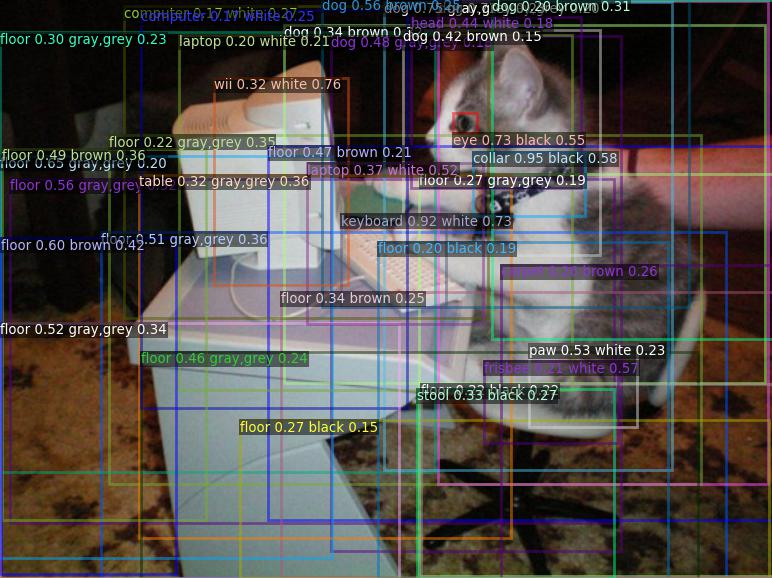

In [13]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [14]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [15]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [16]:
test_question = ["Where is the cat?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [17]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2073, 2003, 1996, 4937, 1029,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [18]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [19]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_vqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[-2.1149,  0.2203,  3.9159,  ..., -1.4886,  3.3830,  1.3415]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [20]:
len(output_vqa["question_answering_score"][0])

3129

In [21]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([1522])

In [22]:
vqa_answers[2534]

'desk'

In [23]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: on toilet


In [24]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: on toilet
Question: ['What is near the disk?']
prediction from LXMERT VQA: cat
Question: ['What is the color of the table?']
prediction from LXMERT VQA: white
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: gray and white
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: square
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


In [25]:
# GQA answer definition
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
gqa_answers = utils.get_data(GQA_URL)
print(len(gqa_answers))
print(gqa_answers[:30])

1842
['cat food', 'elephant', 'gloves', 'football', 'dock', 'shops', 'water', 'light blue', 'chair', 'players', 'tourist', 'magnet', 'railroad', 'ski lift', 'mirror', 'leggings', 'hurdle', 'shuttle', 'wildflowers', 'flowers', 'cooking pot', 'pipe', 'swan', 'girl', 'celery', 'brown', 'ambulance', 'steps', 'power line', 'asphalt']


In [26]:
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [27]:
output_gqa = lxmert_gqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_gqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[1.4717, 0.3860, 0.5656,  ..., 0.6695, 0.1517, 2.7863]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [28]:
len(output_gqa["question_answering_score"][0])

1842

In [29]:
# get prediction
pred_gqa = output_gqa["question_answering_score"].argmax(-1)

pred_gqa

tensor([549])

In [30]:
gqa_answers[549]

'white'

In [31]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


In [32]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: floor
Question: ['What is near the disk?']
prediction from LXMERT VQA: keyboard
Question: ['What is the color of the table?']
prediction from LXMERT VQA: gray
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: gray
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: rectangular
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


In [33]:
# 위 이미지의 URL
URL = "https://metro.co.uk/wp-content/uploads/2015/12/cat.jpg?quality=90&strip=all&zoom=1&resize=644%2C482"#https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [34]:
print(images)
print(sizes)

tensor([[[[-100.9801, -101.3838, -101.9862,  ...,  -96.0043,  -94.7874,
            -93.9801],
          [ -99.7689, -100.1725, -100.7749,  ...,  -95.1968,  -93.9799,
            -93.1726],
          [ -97.9801,  -98.3838,  -98.9862,  ...,  -93.9980,  -92.7848,
            -91.9801],
          ...,
          [ -78.9926,  -79.8074,  -80.9809,  ...,  -86.9432,  -86.9552,
            -86.9552],
          [ -78.9801,  -79.7874,  -80.9497,  ...,  -86.9680,  -86.9801,
            -86.9801],
          [ -78.9801,  -79.7874,  -80.9497,  ...,  -86.9680,  -86.9801,
            -86.9801]],

         [[-111.9465, -112.3502, -112.9526,  ..., -106.9707, -105.7538,
           -104.9465],
          [-110.7353, -111.1389, -111.7413,  ..., -106.1632, -104.9463,
           -104.1390],
          [-108.9465, -109.3502, -109.9526,  ..., -104.9644, -103.7512,
           -102.9465],
          ...,
          [ -53.9590,  -54.3727,  -54.9656,  ...,  -83.8975,  -85.1181,
            -85.9278],
          [ -53.94

In [35]:
test_questions_for_url = [
    "Where is this scene?",
    "what is in the the man's hand?",
    "What's the color of his shoes?"
]

In [36]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj16/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [37]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [38]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [39]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[3.9435e+02, 1.2747e+02, 4.8767e+02, 1.8069e+02],
         [2.8427e+02, 1.7946e+02, 3.7146e+02, 2.5653e+02],
         [3.1982e+02, 2.7844e+00, 5.6031e+02, 3.9253e+02],
         [3.7756e+02, 9.4910e+01, 3.9746e+02, 1.1206e+02],
         [3.6532e+02, 2.2697e+00, 6.3964e+02, 4.0377e+02],
         [0.0000e+00, 1.3117e+02, 2.7655e+02, 4.6545e+02],
         [5.3215e-01, 1.9959e+02, 1.4685e+02, 4.7832e+02],
         [8.0157e+00, 1.4992e+02, 5.1165e+02, 4.3606e+02],
         [2.6841e+02, 0.0000e+00, 5.7438e+02, 2.5631e+02],
         [4.4043e+02, 2.8732e+02, 5.3060e+02, 3.5656e+02],
         [0.0000e+00, 2.6975e+02, 3.3258e+02, 4.8200e+02],
         [8.3758e+01, 1.9450e+02, 6.0540e+02, 4.8200e+02],
         [1.5221e+00, 1.2498e+02, 1.7132e+02, 4.3413e+02],
         [2.7592e+02, 3.1221e+01, 5.1777e+02, 4.5917e+02],
         [2.2374e+02, 1.2267e+02, 6.4400e+02, 4.3412e+02],
         [1.1740e+02, 2.9385e+02, 5.8137e+02, 4.8200e+02],
         [3.4208e+02, 1.5488e+01, 4.8427e+02, 1.5728e+02

In [40]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[0.0000, 0.0000, 0.0233,  ..., 0.0000, 0.3959, 0.1714],
         [2.8967, 0.0000, 0.1804,  ..., 0.0000, 0.0000, 4.4974],
         [0.6888, 0.0000, 0.0892,  ..., 0.0180, 0.0596, 0.9366],
         ...,
         [1.3622, 0.2027, 0.5071,  ..., 0.0245, 2.5489, 0.0000],
         [0.7507, 2.5998, 0.0153,  ..., 0.1879, 1.6932, 1.0203],
         [0.2926, 1.3240, 0.0066,  ..., 0.0000, 0.0491, 1.9339]]])
-------------
torch.Size([1, 36, 2048])


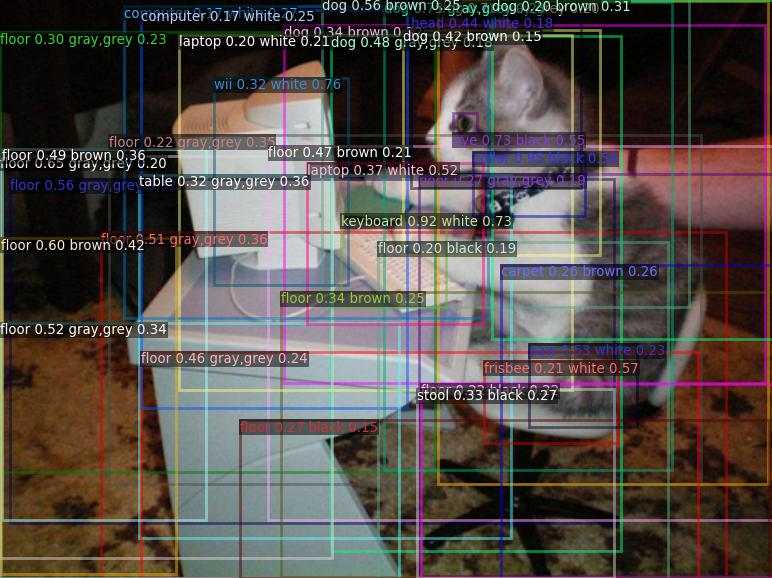

In [41]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())



In [42]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [43]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [44]:
test_question = ["where is this place?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [45]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2073, 2003, 2023, 2173, 1029,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [46]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [47]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_vqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[-3.7143,  0.9160,  2.8885,  ..., -0.5961,  0.5837,  1.6188]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [48]:
len(output_vqa["question_answering_score"][0])

3129

In [49]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([2969])

In [50]:
vqa_answers[2605]

'baseball field'

In [51]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['where is this place?']
prediction from LXMERT VQA: bathroom


In [52]:
test_questions_for_url = [
    "Where is this scene?",
    "What is in the office?",
    "What is it doing?"
]

for test_question in test_questions_for_url:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is this scene?']
prediction from LXMERT VQA: bathroom
Question: ['What is in the office?']
prediction from LXMERT VQA: cat
Question: ['What is it doing?']
prediction from LXMERT VQA: sitting


In [53]:
test_question = ["where is this place?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [54]:
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [55]:
output_gqa = lxmert_gqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_gqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[ 1.7766, -2.3217,  1.7504,  ...,  1.9706,  6.9509,  0.9539]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [56]:
# get prediction
pred_gqa = output_gqa["question_answering_score"].argmax(-1)

pred_gqa

tensor([198])

In [57]:
gqa_answers[61]

'stadium'

In [58]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['where is this place?']
prediction from LXMERT VQA: office


In [59]:
for test_question in test_questions_for_url:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", gqa_answers[pred_gqa])

Question: ['Where is this scene?']
prediction from LXMERT VQA: office
Question: ['What is in the office?']
prediction from LXMERT VQA: desk
Question: ['What is it doing?']
prediction from LXMERT VQA: sitting


VQA와 GQA에서 모두 대체적으로 만족할 만한 답을 냈다. 다만 GQA에서는 장소가 어디냐고 물었을 때 office라는 정확한 답을 낸 반면 VQA에서는 장소를 물었을 때 bathroom이라는 답을 냄으로써 VQA2 데이터셋이 좀 더 정교하게 학브